In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
import json
%matplotlib inline
import requests
from bs4 import BeautifulSoup

# Scraping

#### We will start by using postman to spy on the get requests that are sent for both website, in order to retrieve the url that loads the rankings in the corresponding websites. To do this, we send requests to both websites and retrieve the information as json files and extract two dictionarries that will be used to form the dataframes

In [2]:
r_THE = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
r_QS = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508593854921')

data_THE = r_THE.json() #ranking data for timeshighereducation.com
data_QS = r_QS.json()  #ranking data for topuniversities.com

##### We only took the data part for each json, which is of interest

In [3]:
print(list(data_THE.keys()))
print(list(data_QS.keys()))

['pillars', 'locations', 'subjects', 'data']
['data']


In [4]:
df_rank_THE = pd.DataFrame(data_THE['data'])
df_rank_QS = pd.DataFrame(data_QS['data'])

##### We create the two dataframes and drop all the universites ranked above 200

In [5]:
# We need to clean the rankings in replacing first special characters

df_rank_THE['rank'] = df_rank_THE['rank'].replace("=|–|\+", "", regex=True).astype(int)
df_rank_THE = df_rank_THE.drop(df_rank_THE[df_rank_THE['rank'] > 200].index)

df_rank_QS['rank_display'] = df_rank_QS['rank_display'].replace("=|-|\+", "", regex=True).astype(int)
df_rank_QS = df_rank_QS.drop(df_rank_QS[df_rank_QS['rank_display'] > 200].index)

##### Then, we select the required features for both dataframes

In [6]:
THE_features = ['name', 'location', 'rank', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']
df_rank_THE = df_rank_THE[THE_features]

df_rank_THE = df_rank_THE.set_index('name').sort_index(ascending=True)
df_rank_THE.index.name = 'University'


In [7]:
QS_features = ['country', 'region', 'rank_display']

df_rank_QS = df_rank_QS.set_index('title').sort_index(ascending=True)

urls = df_rank_QS['url'] # We need to search further informations as the list isn't exhaustive, hence the url we are saving 
df_rank_QS = df_rank_QS[QS_features]

# Question 1

##### For the first webpage, we need to scrap more data from the detail page of each university. Postman was very helpful for finding tags with the corresponing informations.

In [8]:
link = 'https://www.topuniversities.com/'
university = {'title': [],
              'faculty members total': [],
              'faculty members international': [],
              'students total': [],
              'students international': []}

for uni in urls.iteritems():
    soup = BeautifulSoup(requests.get(link + uni[1]).text, 'html.parser')
    
    faculty = soup.find('div', class_='faculty-main wrapper col-md-4 item active')
    if faculty is not None:
        faculty = faculty.find_all('div', class_='number')
        
    students = soup.find('div', class_='students-main wrapper col-md-4 item')
    if students is not None:
        students = students.find('div', class_='number')
    
    int_students = soup.find('div', class_='int-students-main wrapper col-md-4 item')
    if int_students is not None:
        int_students = int_students.find('div', class_='number')
    
    
    if faculty is not None:
        if len(faculty) > 1:
            university['faculty members total'].append(int(faculty[0].text.replace(',', '')))
            university['faculty members international'].append(int(faculty[1].text.replace(',', '')))
        else:
            university['faculty members total'].append(int(faculty[0].text.replace(',', '')))
            university['faculty members international'].append(None)
    else:
        university['faculty members total'].append(None)
        university['faculty members international'].append(None)
        
        
    if students is not None:
        university['students total'].append(int(students.text.replace(',', '')))
        
    else:
        university['students total'].append(None)
    
    if int_students is not None:
        university['students international'].append(int(int_students.text.replace(',', '')))
        
    else:
        university['students international'].append(None)

    university['title'].append(uni[0])
        

##### We join the original dataframe with the additional informations collected and rearrange headers in a intuitive way

In [9]:
df_rank_QS_supp = pd.DataFrame(university).set_index('title')
df_rank_QS = df_rank_QS.join(df_rank_QS_supp)

In [10]:
col = [('', 'Country'), ('', 'Region'), ('', 'Rank'), ('Faculty members', 'international'), ('Faculty members', 'total'), ('Students', 'international'), ('Students', 'total')]
df_rank_QS.columns = pd.MultiIndex.from_tuples(col)
df_rank_QS.index.name = 'University'

## University

In [11]:
QS_ratio_university = df_rank_QS.copy()

QS_ratio_university['Ratio', 'faculty/students'] = QS_ratio_university['Faculty members', 'total'] / QS_ratio_university['Students', 'total']
QS_ratio_university['Ratio', 'international/total'] = QS_ratio_university['Students', 'international'] / QS_ratio_university['Students', 'total']

### Best faculty/students ratio

In [12]:
QS_ratio_university = QS_ratio_university.sort_values(('Ratio', 'faculty/students'), ascending=False)

In [13]:
def plot_ratio(dataframe, ratio, title):
    fig, axe = plt.subplots(figsize=(20, 10))
    plt.title('Proportion of '+ str(title), fontsize=30)
    plt.xticks(rotation=90, fontsize=20 )

    sns.barplot( x=dataframe.index[:20], y=dataframe['Ratio', ratio][:20])
    axe.set_ylabel('Ratio ' + str(ratio), fontsize=20)
    axe.set_xlabel('')

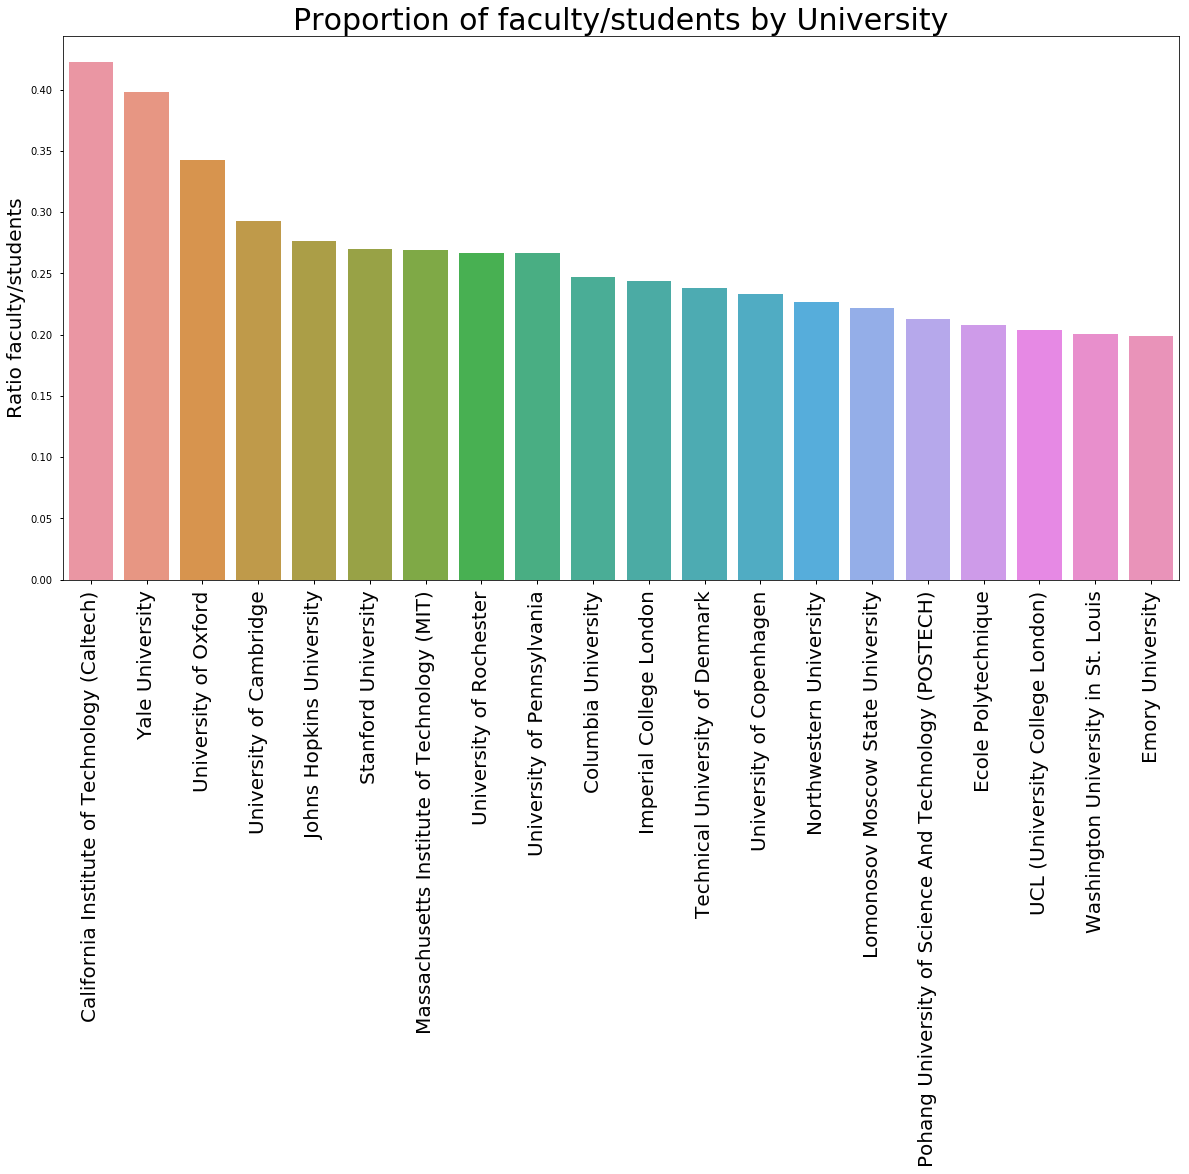

In [14]:
plot_ratio(QS_ratio_university, 'faculty/students', 'faculty/students by University')

### Best international ratio

In [15]:
QS_ratio_university = QS_ratio_university.sort_values(('Ratio', 'international/total'), ascending=False)

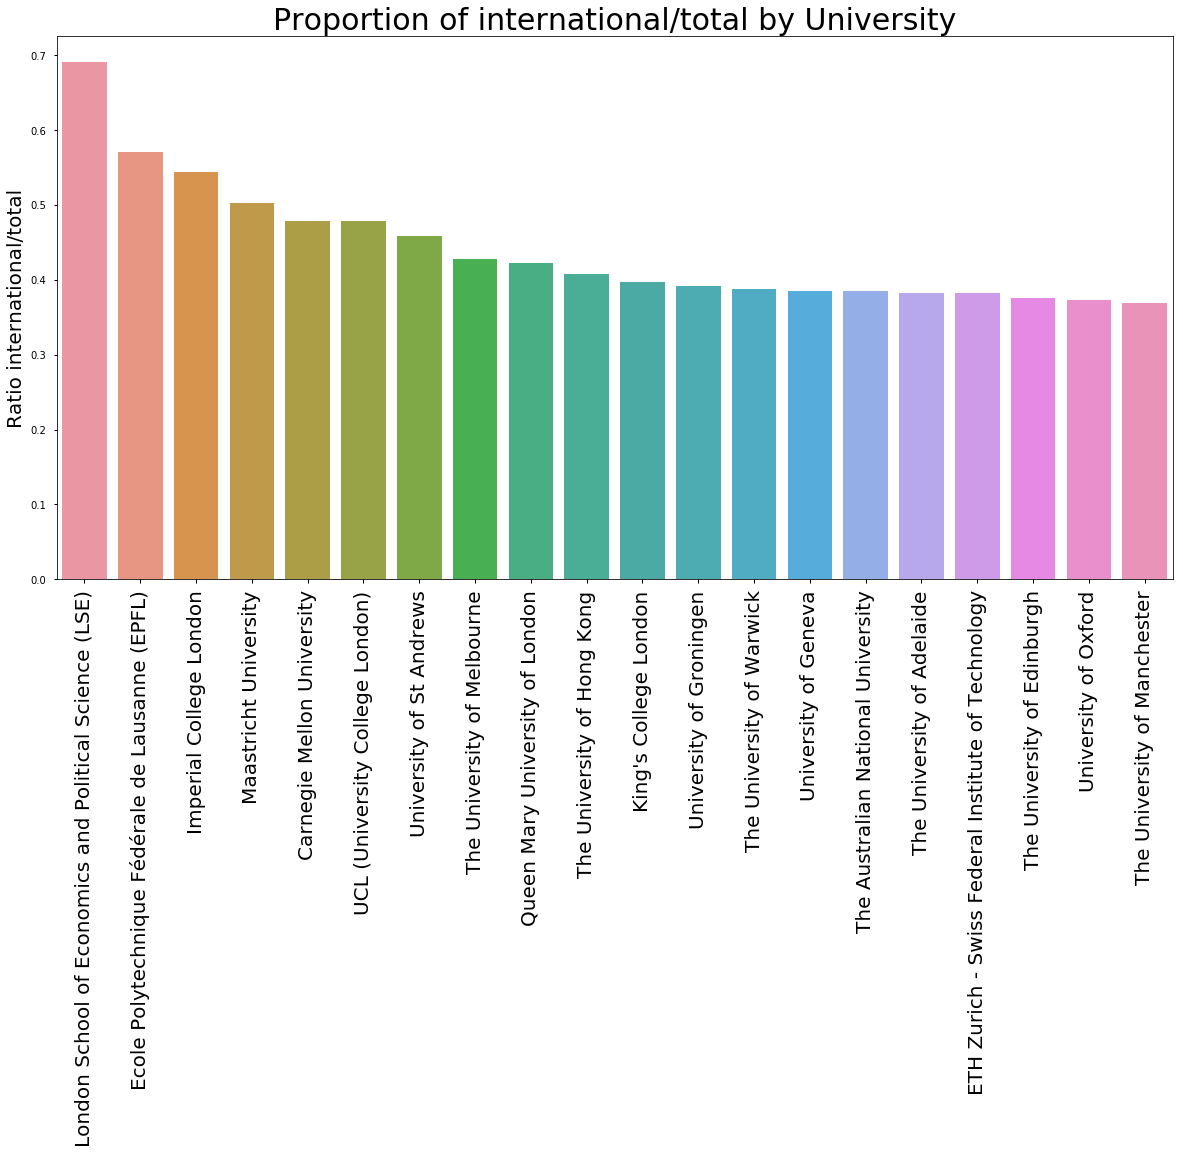

In [16]:
plot_ratio(QS_ratio_university, 'international/total', 'international/total by University')

## Country

In [17]:
QS_ratio_country = df_rank_QS.copy()
QS_ratio_country = QS_ratio_country.groupby([('', 'Country')]).sum()[['Faculty members', 'Students']]
QS_ratio_country.index.name = 'Country'

QS_ratio_country['Ratio', 'faculty/students'] = QS_ratio_country['Faculty members', 'total']/QS_ratio_country['Students', 'total']
QS_ratio_country['Ratio', 'international/total'] = QS_ratio_country['Students', 'international']/QS_ratio_country['Students', 'total']

### Best faculty/student ratio

In [18]:
QS_ratio_country = QS_ratio_country.sort_values(('Ratio', 'faculty/students'), ascending=False)

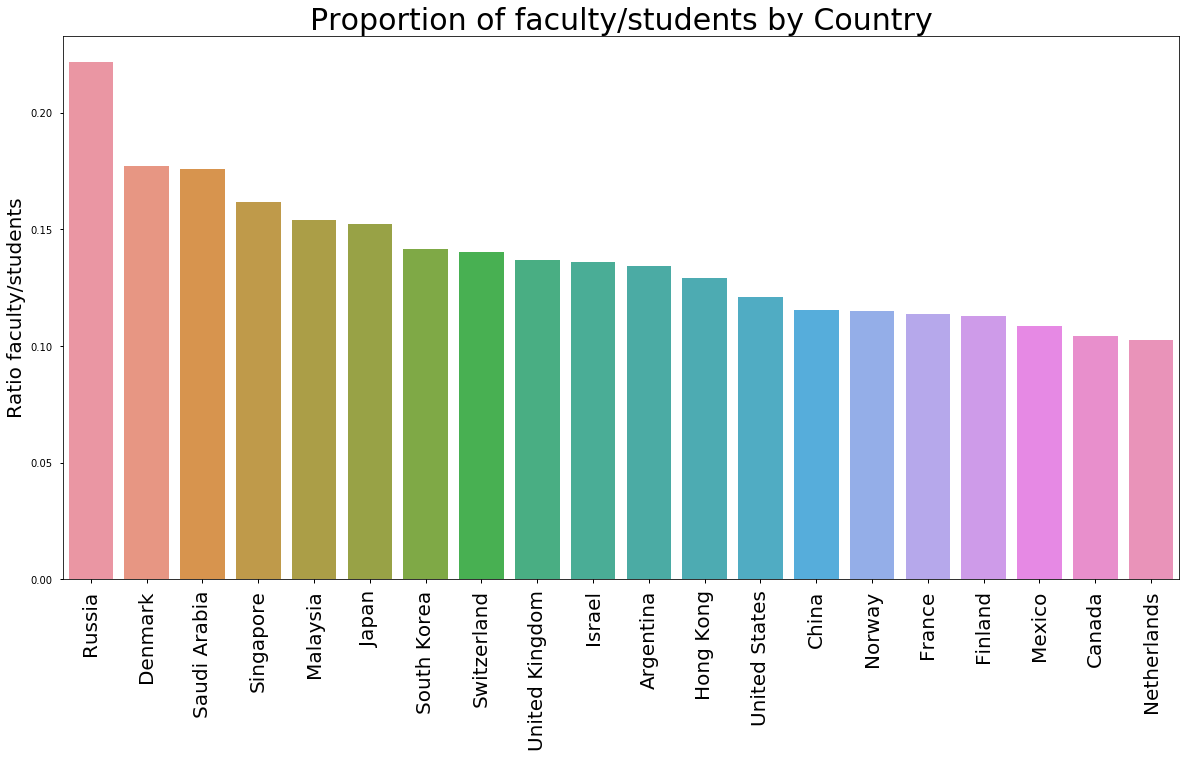

In [19]:
plot_ratio(QS_ratio_country, 'faculty/students', 'faculty/students by Country')

### Best international ratio

In [20]:
QS_ratio_country = QS_ratio_country.sort_values(('Ratio', 'international/total'), ascending=False)

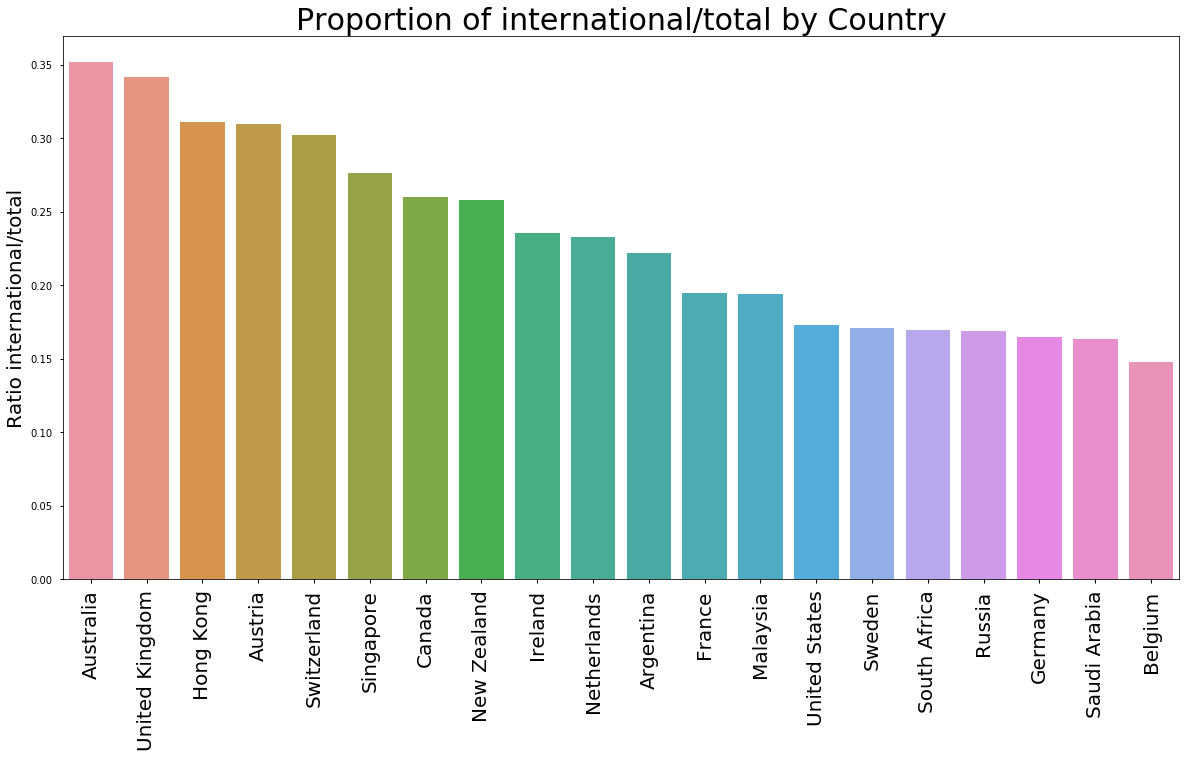

In [21]:
plot_ratio(QS_ratio_country, 'international/total', 'international/total by Country')

## Region

In [22]:
QS_ratio_region = df_rank_QS.copy()
QS_ratio_region = QS_ratio_region.groupby([('', 'Region')]).sum()[['Faculty members', 'Students']]
QS_ratio_region.index.name = 'Region'

QS_ratio_region['Ratio', 'faculty/students'] = QS_ratio_region['Faculty members', 'total']/QS_ratio_region['Students', 'total']
QS_ratio_region['Ratio', 'international/total'] = QS_ratio_region['Students', 'international']/QS_ratio_region['Students', 'total']

### Best faculty/student ratio

In [23]:
QS_ratio_region = QS_ratio_region.sort_values(('Ratio', 'faculty/students'), ascending=False)

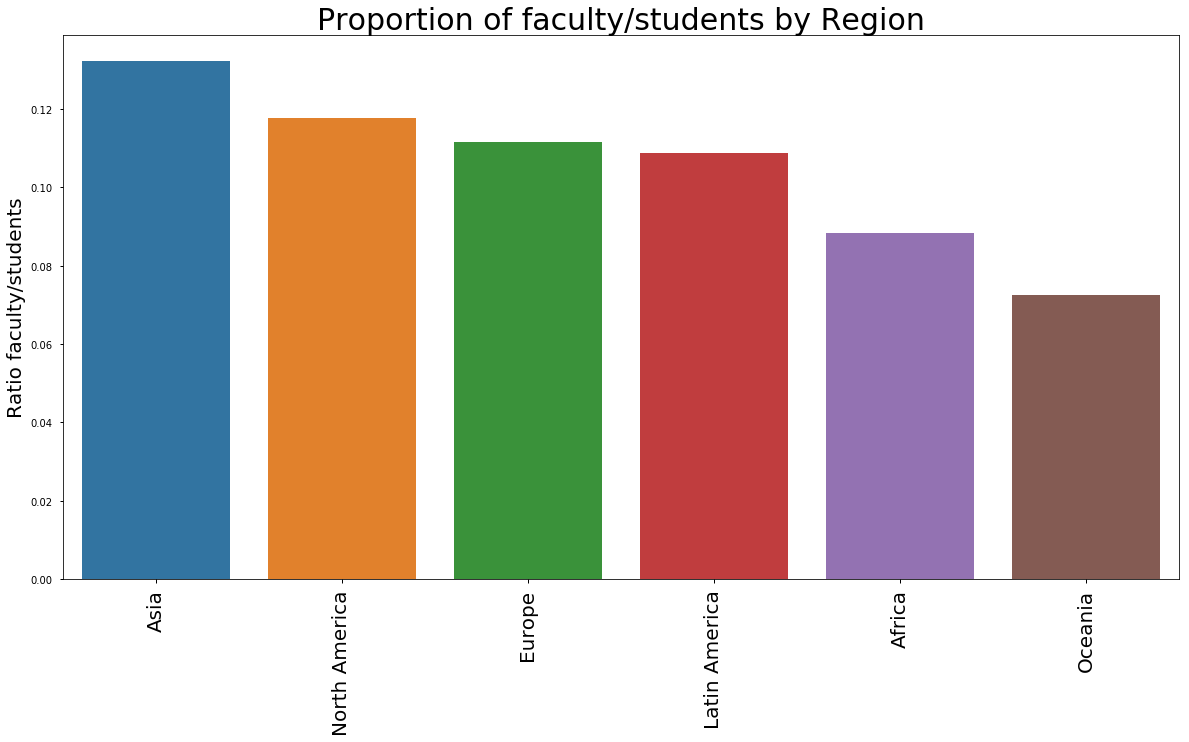

In [24]:
plot_ratio(QS_ratio_region, 'faculty/students', 'faculty/students by Region')

### Best international ratio

In [25]:
QS_ratio_region = QS_ratio_region.sort_values(('Ratio', 'international/total'), ascending=False)

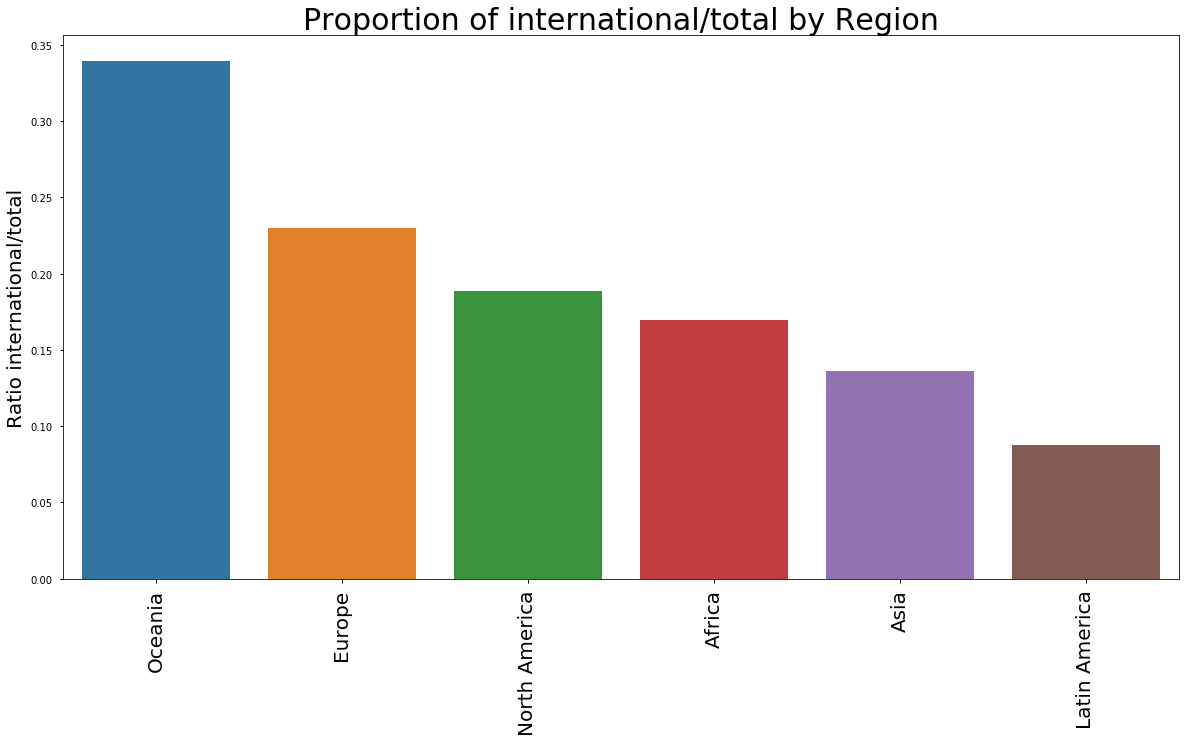

In [26]:
plot_ratio(QS_ratio_region, 'international/total', 'international/total by Region')

# Question 2

In [27]:
df_rank_THE['stats_number_students'] = df_rank_THE['stats_number_students'].replace(',', '', regex=True)
df_rank_THE['stats_pc_intl_students'] = df_rank_THE.stats_pc_intl_students.apply(lambda x: float(x.replace('%', ''))/100)
df_rank_THE['stats_student_staff_ratio'] = df_rank_THE.stats_student_staff_ratio.apply(lambda x: 1/float(x))

In [28]:
col = [('', 'Country'),('', 'Rank'), ('Students', 'total'), ('Ratio', 'international/total'), ('Ratio', 'faculty/students')]

df_rank_THE.columns = pd.MultiIndex.from_tuples(col)

df_rank_THE['Students', 'international'] = df_rank_THE[('Students', 'total')].astype(int) * df_rank_THE[('Ratio', 'international/total')].astype(float)
df_rank_THE['Faculty', 'total'] = df_rank_THE[('Ratio', 'faculty/students')].astype(float) * df_rank_THE[('Students', 'total')].astype(int)

df_rank_THE['Faculty', 'total'] = df_rank_THE['Faculty', 'total'].astype(int)
df_rank_THE['Students', 'total'] = df_rank_THE['Students', 'total'].astype(int)


#### We add the region column to the df_rank_THE dataframe with the help of a dictionary created from df_rank_QS

In [29]:
region = dict()

for ind in range(0, len(df_rank_QS)):
    region[df_rank_QS['', 'Country'].iloc[ind]] = df_rank_QS['','Region'].iloc[ind]

region['Luxembourg'] = 'Europe'

In [30]:
# Changing some Country name to match better both websites
df_rank_THE['', 'Country'].replace('Russian Federation', 'Russia', inplace=True)

region_THE = [region[x] if x in region.keys() else None for x in df_rank_THE['', 'Country']]
df_rank_THE['', 'Region'] = region_THE


df_rank_THE = df_rank_THE[[('', 'Country'), ('', 'Region'), ('', 'Rank'), ('Faculty', 'total'), ('Students', 'international'), ('Students', 'total'), ('Ratio', 'faculty/students'), ('Ratio', 'international/total')]]

In [31]:
THE_ratio_university = df_rank_THE.copy()

## University

### Best faculty/student ratio

In [32]:
THE_ratio_university = THE_ratio_university.sort_values(('Ratio', 'faculty/students'), ascending=False)

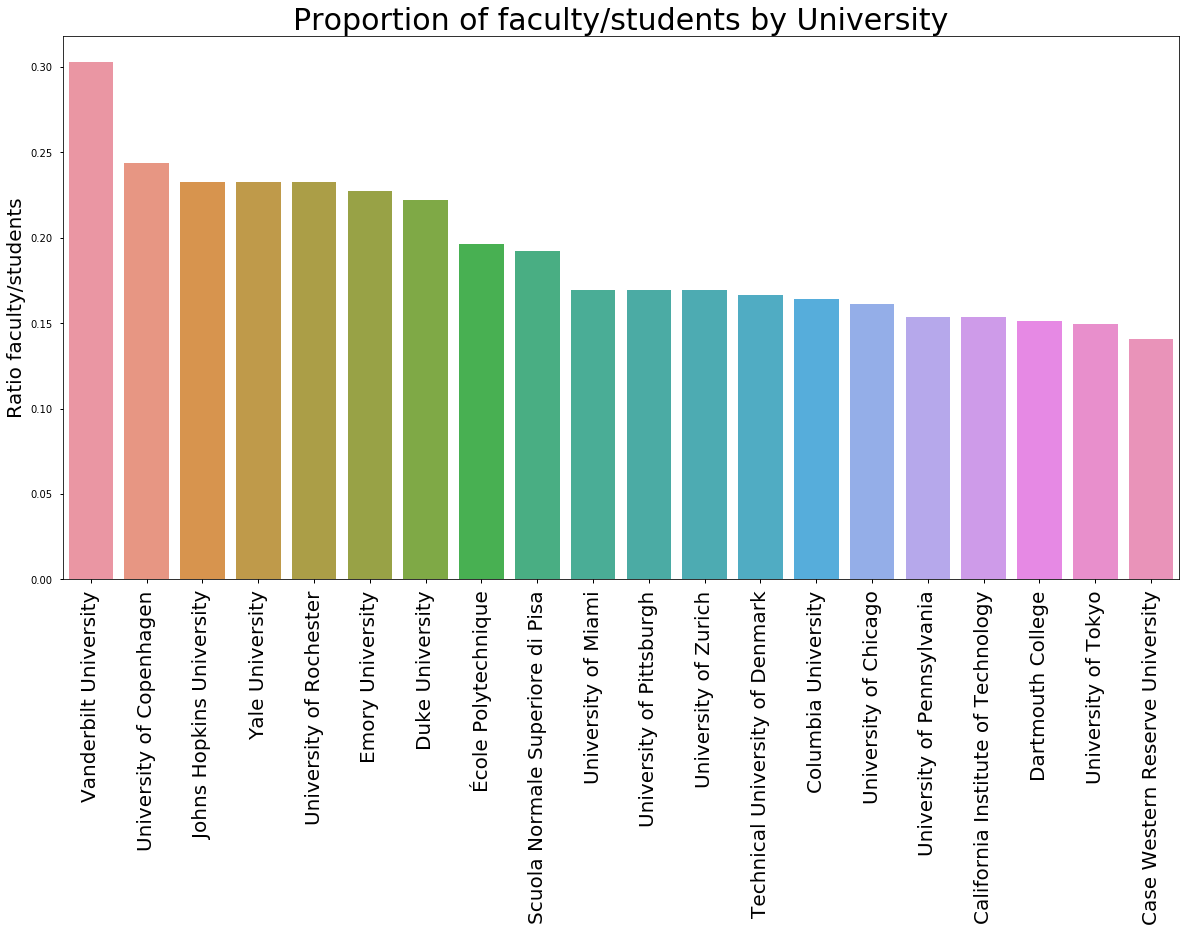

In [33]:
plot_ratio(THE_ratio_university, 'faculty/students', 'faculty/students by University')

### Best international ratio

In [34]:
THE_ratio_university = THE_ratio_university.sort_values(('Ratio', 'international/total'), ascending=False)

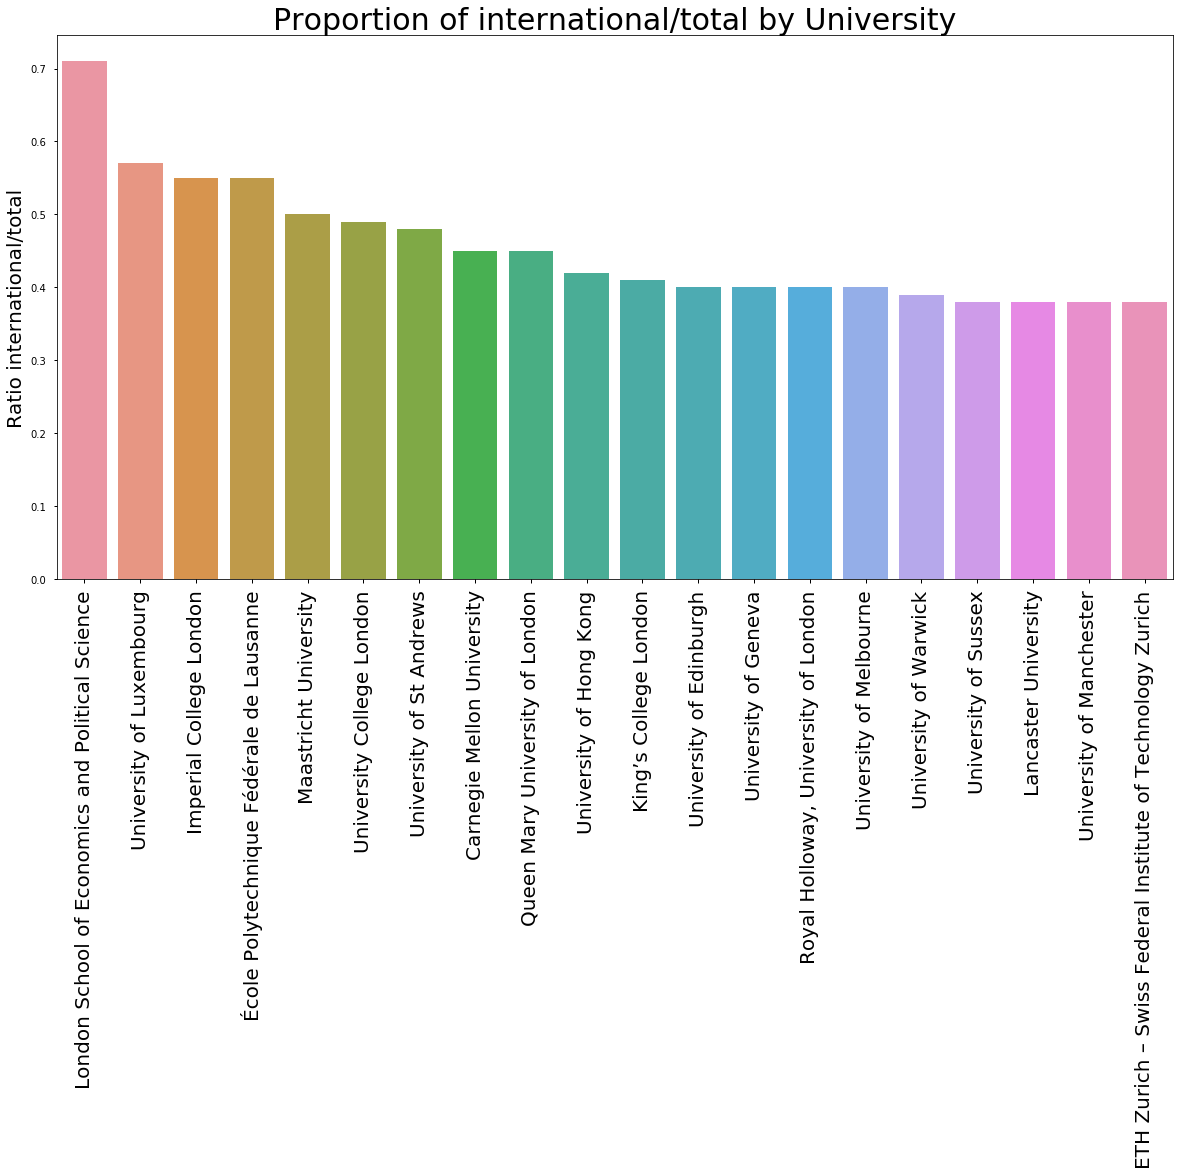

In [35]:
plot_ratio(THE_ratio_university, 'international/total', 'international/total by University')

## Country

In [36]:
THE_ratio_country = df_rank_THE.copy()
THE_ratio_country = THE_ratio_country.groupby([('', 'Country')]).sum()[['Faculty', 'Students']]
THE_ratio_country.index.name = 'Country'

THE_ratio_country['Ratio', 'faculty/students'] = THE_ratio_country['Faculty', 'total']/THE_ratio_country['Students', 'total']
THE_ratio_country['Ratio', 'international/total'] = THE_ratio_country['Students', 'international']/THE_ratio_country['Students', 'total']

### Best faculty/student ratio

In [37]:
THE_ratio_country = THE_ratio_country.sort_values(('Ratio', 'faculty/students'), ascending=False)

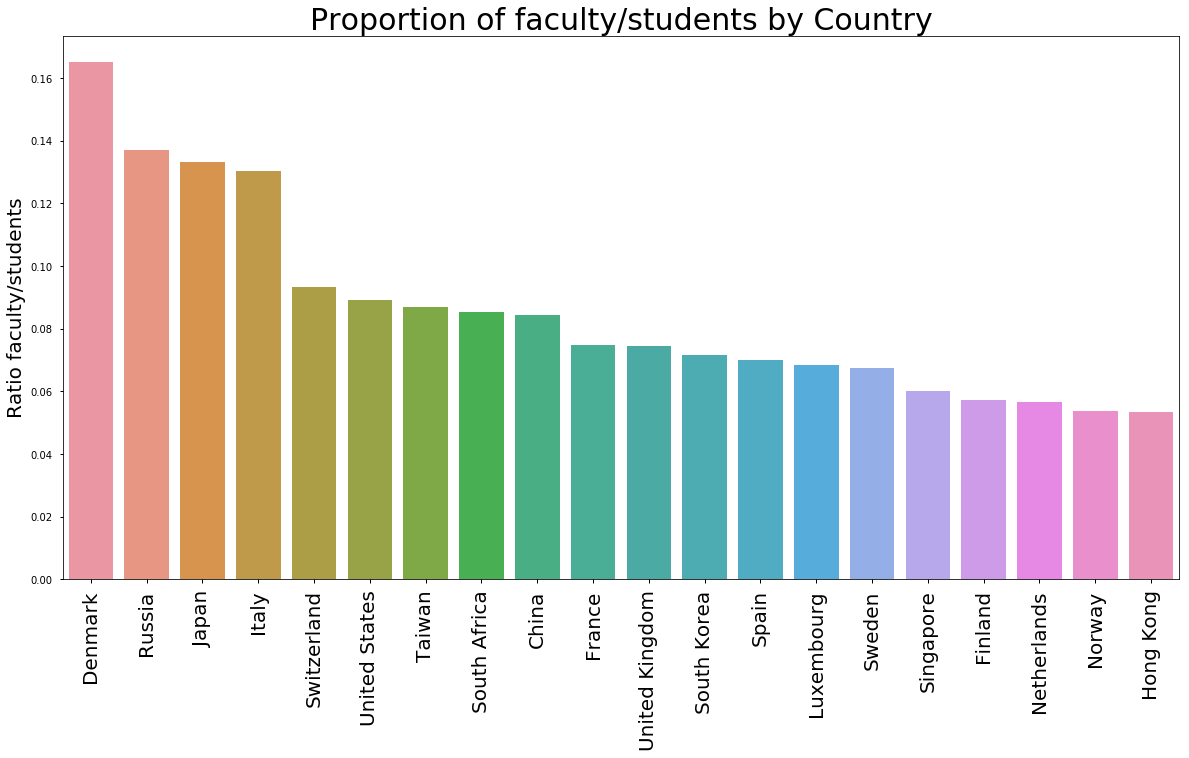

In [38]:
plot_ratio(THE_ratio_country, 'faculty/students', 'faculty/students by Country')

### Best international ratio

In [39]:
THE_ratio_country = THE_ratio_country.sort_values(('Ratio', 'international/total'), ascending=False)

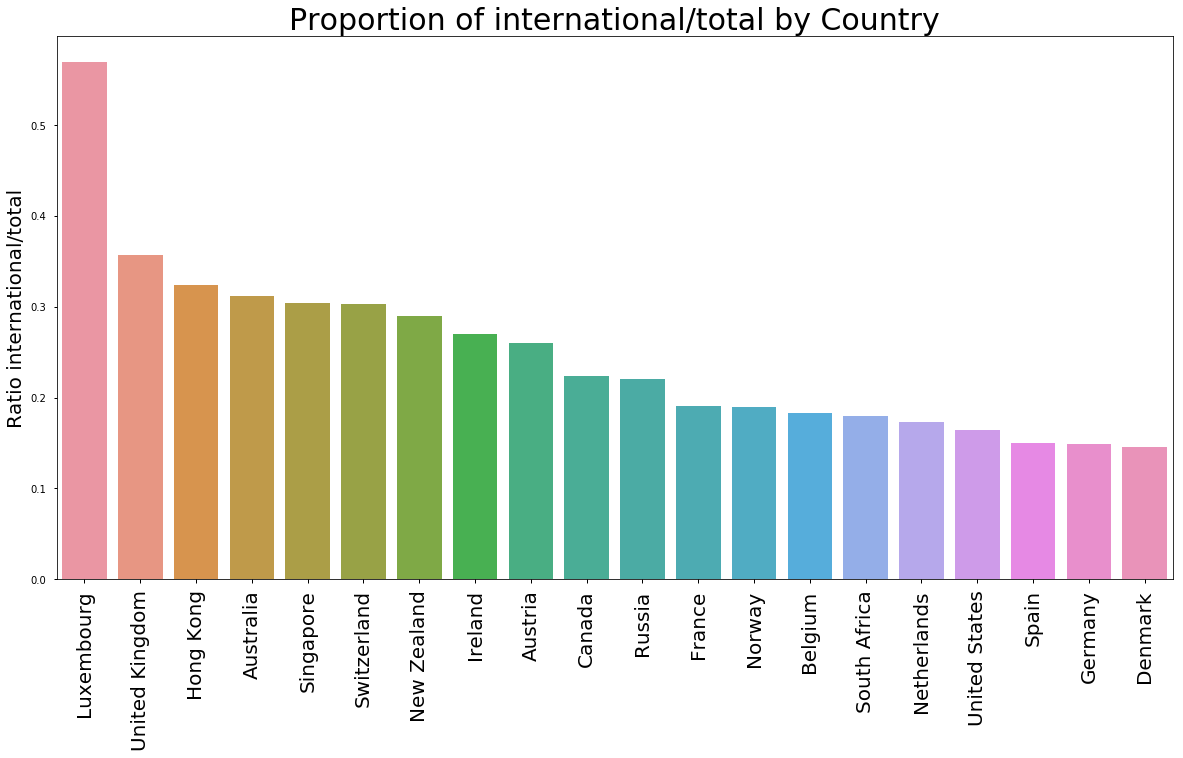

In [40]:
plot_ratio(THE_ratio_country, 'international/total', 'international/total by Country')

In [41]:
THE_ratio_region = df_rank_THE.copy()
THE_ratio_region = THE_ratio_region.groupby([('', 'Region')]).sum()[['Faculty', 'Students']]
THE_ratio_region.index.name = 'Country'

THE_ratio_region['Ratio', 'faculty/students'] = THE_ratio_region['Faculty', 'total']/THE_ratio_region['Students', 'total']
THE_ratio_region['Ratio', 'international/total'] = THE_ratio_region['Students', 'international']/THE_ratio_region['Students', 'total']

### Best faculty/student ratio

In [42]:
THE_ratio_region = THE_ratio_region.sort_values(('Ratio', 'faculty/students'), ascending=False)

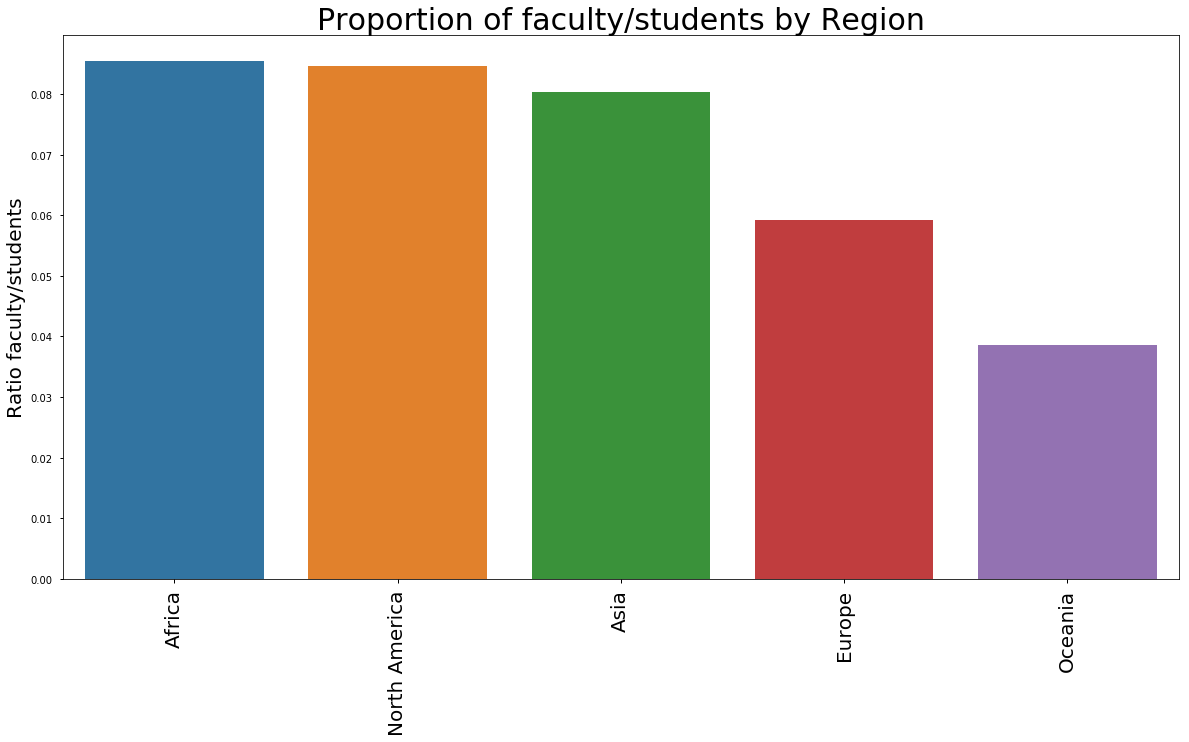

In [43]:
plot_ratio(THE_ratio_region, 'faculty/students', 'faculty/students by Region')

### Best international ratio

In [44]:
THE_ratio_region = THE_ratio_region.sort_values(('Ratio', 'international/total'), ascending=False)

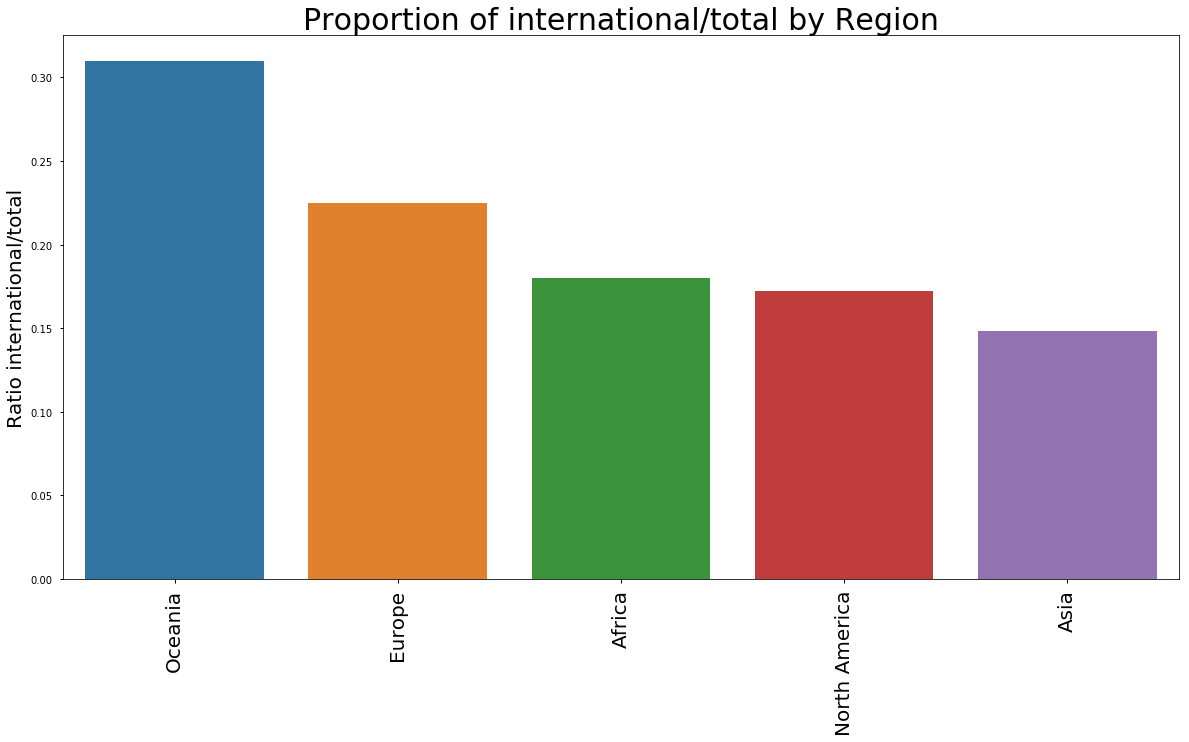

In [45]:
plot_ratio(THE_ratio_region, 'international/total', 'international/total by Region')

### Best international ratio

# Question 3